In [1]:
from whitening_model import *
import pandas as pd
from utils import *
from tqdm import trange
import seaborn as sns
import matplotlib.pyplot as plt
from trading_model import *
from AR_model import *
import itertools
sns.set()
sns.set(font_scale=1.5)
import scipy

%load_ext autoreload
%autoreload 2

In [407]:
FF = pd.read_csv('FF_data.CSV')
FF = FF.rename(columns={'Unnamed: 0': "date"})
FF.index = pd.to_datetime(FF['date'].astype(str), format='%Y/%m/%d')
FF = FF.drop(['date', 'RF'], axis=1)
FF = FF/100
# FF = FF.loc['1985-01-01':'2000-01-01']
# FF = FF.loc['2000-01-01':]


train_frac = 0.35
val_frac = 0.35
train_len = int(train_frac*FF.shape[0])
val_len = int(val_frac*FF.shape[0])
data = FF.values
dates = FF.index

winsorize = False
if winsorize:
        data[:train_len+val_len] = np.maximum(data[:train_len+val_len], np.percentile(data[:train_len+val_len], 1, axis=0))
        data[:train_len+val_len] = np.minimum(data[:train_len+val_len], np.percentile(data[:train_len+val_len], 99, axis=0))

In [408]:
FF[:train_len+val_len]

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
1963-07-01,-0.0067,0.0002,-0.0035,0.0003,0.0013
1963-07-02,0.0079,-0.0028,0.0028,-0.0008,-0.0021
1963-07-03,0.0063,-0.0018,-0.0010,0.0013,-0.0025
1963-07-05,0.0040,0.0009,-0.0028,0.0007,-0.0030
1963-07-08,-0.0063,0.0007,-0.0020,-0.0027,0.0006
...,...,...,...,...,...
2004-12-14,0.0045,0.0049,-0.0017,-0.0008,0.0003
2004-12-15,0.0033,0.0040,0.0046,-0.0037,0.0019
2004-12-16,-0.0028,-0.0048,0.0028,0.0023,0.0022


# Volatility and correlations over time

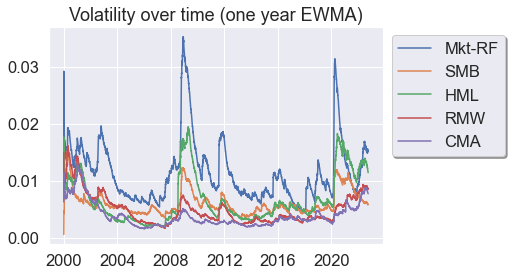

In [6]:
T_half = 50
beta = np.exp(-np.log(2)/T_half)
daily_covs = get_daily_covs(FF.values)
EWMAs_temp = get_EWMAs(daily_covs, beta)
for i in range(5):
    plt.plot(dates, np.sqrt(EWMAs_temp[:,i,i]), label=FF.columns[i])
plt.title("Volatility over time (one year EWMA)")
plt.legend(bbox_to_anchor=(1, 1),
          ncol=1, fancybox=True, shadow=True)
plt.show()

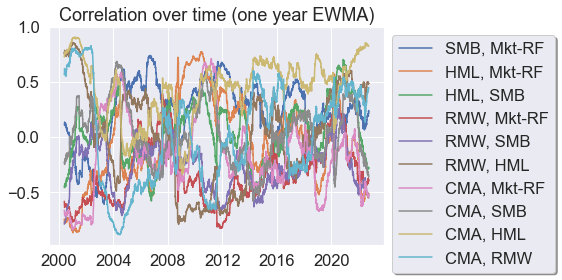

In [7]:
for i in range(5):
    for j in range(i):
        plt.plot(dates[100:], EWMAs_temp[100:][:,i,j]/\
            np.sqrt(EWMAs_temp[100:][:,i,i]*EWMAs_temp[100:][:,j,j]),\
             label=FF.columns[i]+', ' + FF.columns[j])
plt.title("Correlation over time (one year EWMA)")
plt.legend(bbox_to_anchor=(1, 1),
          ncol=1, fancybox=True, shadow=True)
plt.show()

# EWMA benchmark

In [167]:
np.cumsum(data, axis=0).shape

(5724, 5)

In [121]:
# T_half1 = 5
# T_half2 = 21
# T_half3 = 63
# pred_horizon=0

# beta1 = np.exp(-np.log(2)/T_half1)
# beta2 = np.exp(-np.log(2)/T_half2)
# beta3 = np.exp(-np.log(2)/T_half3)

# (sqrt_size_hats, sqrt_V_hats, sqrt_Sigma_hats), (r_tildes_size, r_tildes_var, r_tildes_full), R_new, skipped_R  \
#     = get_whitened_data(data, whitener='tripple', beta=(beta1,beta2,beta3), EWMA_reg=0)
# EWMAs = (sqrt_size_hats, sqrt_V_hats, sqrt_Sigma_hats)
# tildes = (r_tildes_size, r_tildes_var, r_tildes_full)

# X_lagged, y_lagged, R_lagged, EWMAs_lagged = get_AR_format(r_tildes_full, 1, R_new, EWMAs, pred_horizon=pred_horizon)

# X_train = X_lagged[:, :train_len]
# X_val = X_lagged[:, train_len:train_len+val_len]
# y_train = y_lagged[:, :train_len]
# y_val = y_lagged[:, train_len:train_len+val_len]
# EWMAs_train = (EWMAs_lagged[0][:train_len], EWMAs_lagged[1][:train_len], EWMAs_lagged[2][:train_len])
# EWMAs_val = (EWMAs_lagged[0][train_len:train_len+val_len], EWMAs_lagged[1][train_len:train_len+val_len], EWMAs_lagged[2][train_len:train_len+val_len])
# R_train = R_lagged[:train_len]
# R_val = R_lagged[train_len:train_len+val_len]



# # Train model
# beta = np.exp(-np.log(2)/T_half)
# r_tilde_full_EWMAs =  get_EWMAs(r_tildes_full, beta)
# r_tilde_full_EWMAs_test = r_tilde_full_EWMAs[train_len+val_len:-1]
# EWMAs_test = (EWMAs[0][])


# As, X_vals, R_vals = get_As(X_train, y_train, X_val, y_val, R_val, alpha, weighted, update_period)
# r_tilde_full_hat, R = predict_periodically(As, X_vals, R_vals)
# r_tilde_var_hat = get_R(EWMAs_val[2], r_tilde_full_hat)
# r_tilde_size_hat = get_R(EWMAs_val[1], r_tilde_var_hat)
# r_hat = r_tilde_size_hat * EWMAs_val[0]

In [377]:
T_half = 50
pred_horizon = 0

beta = np.exp(-np.log(2)/T_half)
EWMAs, r_tildes, R_new, skipped_R = get_whitened_data(data, whitener='Cov', beta=beta, EWMA_reg=0)

# X_lagged, y_lagged, R_lagged, EWMAs_lagged = get_AR_format(r_tildes, 1, R_new, EWMAs, pred_horizon=pred_horizon)

beta = np.exp(-np.log(2)/T_half)
r_tilde_ewmas = get_EWMAs(r_tildes, beta)
r_tilde_ewmas = r_tilde_ewmas[train_len+val_len:-1]
R_test = R_new[train_len+val_len+1:]

EWMAs_test = EWMAs[train_len+val_len+1:]
r_hat = get_R(EWMAs_test, r_tilde_ewmas)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat.flatten(), R_test.flatten())
print(f"Correlation: {r_value:.2%}")
print(f"Beta:  {slope:.2}")
print(f"Excess signs: {np.mean(np.sign(r_hat) == np.sign(R_test))-np.mean(R_test>0):.2%}")

Correlation: -1.69%
Beta:  -0.17
Excess signs: 1.00%


In [400]:
T_half = 50
pred_horizon = 0
X_lagged, y_lagged, R_lagged = get_AR_format(data, 1, pred_horizon=pred_horizon)


beta = np.exp(-np.log(2)/T_half)
r_ewmas = get_EWMAs(y_lagged.T, beta)
r_ewmas_test = r_ewmas[train_len+val_len:-1]
data_test = y_lagged.T[train_len+val_len+1:]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_ewmas_test.flatten(), data_test.flatten())
print(f"Correlation: {r_value:.2%}")
print(f"Beta:  {slope:.2}")
print(f"Excess signs: {np.mean(np.sign(r_ewmas_test) == np.sign(data_test))-np.mean(data_test>0):.2%}")

Correlation: -1.08%
Beta:  -0.14
Excess signs: 1.09%


# No whitening

In [441]:
pred_horizon = 0
weighted = True

update_period = int(252*2)

### Define features
sigmas = np.std(data[:train_len+val_len], axis=0).reshape(1,-1)
hi = get_hi(data, sigmas)
lo = get_lo(data, sigmas)
pos = get_pos(data)
neg = get_neg(data)

ma2 = moving_average(data, 2)
sigmas2 = np.std(ma2[:train_len+val_len], axis=0).reshape(1,-1)
hi2 = get_hi(ma2, sigmas2)
lo2 = get_lo(ma2, sigmas2)
pos2 = get_pos(ma2)
neg2 = get_neg(ma2)

ma4 = moving_average(data, 4)
sigmas4 = np.std(ma4[:train_len+val_len], axis=0).reshape(1,-1)
hi4 = get_hi(ma4, sigmas4)
lo4 = get_lo(ma4, sigmas4)
pos4 = get_pos(ma4)
neg4 = get_neg(ma4)

ma8 = moving_average(data, 8)
sigmas8 = np.std(ma8[:train_len+val_len], axis=0).reshape(1,-1)
hi8 = get_hi(ma8, sigmas8)
lo8 = get_lo(ma8, sigmas8)
pos8 = get_pos(ma8)
neg8 = get_neg(ma8)

ma16 = moving_average(data, 16)
sigmas16 = np.std(ma16[:train_len+val_len], axis=0).reshape(1,-1)
hi16 = get_hi(ma16, sigmas16)
lo16 = get_lo(ma16, sigmas16)
pos16 = get_pos(ma16)
neg16 = get_neg(ma16)

ma32 = moving_average(data, 32)
sigmas32 = np.std(ma32[:train_len+val_len], axis=0).reshape(1,-1)
hi32 = get_hi(ma32, sigmas32)
lo32 = get_lo(ma32, sigmas32)
pos32 = get_pos(ma32)
neg32 = get_neg(ma32)

features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, ma16, ma32, hi2, hi4, hi8, hi16, hi32, lo2, lo4, lo8, lo16, lo32,\
    pos2, pos4, pos8, pos16, pos32, neg2, neg4, neg8, neg16, neg32])

# features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, ma16, hi2, hi4, hi8, hi16, lo2, lo4, lo8, lo16,\
#     pos2, pos4, pos8, pos16, neg2, neg4, neg8, neg16])

alphas = [10**i for i in range(-10,7)]
horizons = np.arange(1,21)
horizons = [1]

correlations = []
MSEs = []
for i in trange(len(alphas)):
    alpha = alphas[i]
    for memory in horizons:

        ### Get data in lagged format
        X_lagged, y_lagged, R_lagged = get_AR_format_with_features(data, memory, features, pred_horizon=pred_horizon)
   
        X_train = X_lagged[:, :train_len]
        X_val = X_lagged[:, train_len:train_len+val_len]
        y_train = y_lagged[:, :train_len]
        y_val = y_lagged[:, train_len:train_len+val_len]
        R_train = R_lagged[:train_len]
        R_val = R_lagged[train_len:train_len+val_len]

        # Train model
        As, X_vals, R_vals = get_As(X_train, y_train, X_val, y_val, R_val, alpha, weighted, update_period)
        r_hat, R = predict_periodically(As, X_vals, R_vals)

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat.flatten(), R.flatten())

        excess_signs = np.mean(np.sign(r_hat) == np.sign(R_val))-np.mean(R_val>0)
        
        correlations.append([alpha, memory, r_value, slope, excess_signs])

        # correlations.append([alpha, memory, np.corrcoef(r_hat.flatten(), y_val.T.flatten())[0,1]])
        MSEs.append([alpha, memory, np.sqrt(np.mean((r_hat-y_val.T)**2))])
correlations = np.array(correlations)
MSEs = np.array(MSEs)
metrics = {"MSE": MSEs, "Correlation": correlations}

100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Best x:  1.0
Best y:  1e-05
Maximum validation corr: 16.08%
beta: 0.64
excess signs: 4.49%


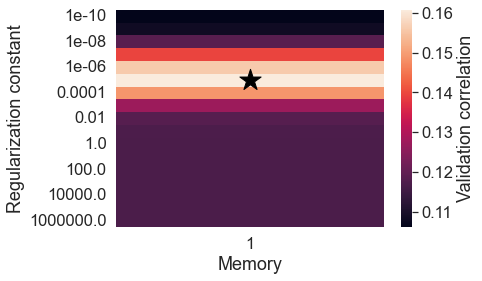

In [442]:
plot_heatmap(metrics, "Regularization constant", "Memory", metric="Correlation")

In [443]:
### Get data in lagged format
memory_nw = 1
alpha_nw = 1e-5

X_lagged, y_lagged, R_lagged, dates_lagged = get_AR_format_with_features(data, memory_nw, features, dates=dates, pred_horizon=pred_horizon)
X_train = X_lagged[:, train_len:train_len+val_len]
y_train = y_lagged[:, train_len:train_len+val_len]
X_test = X_lagged[:, train_len+val_len:]
y_test = y_lagged[:, train_len+val_len:]
R_train = R_lagged[:train_len+val_len]
R_test_nw = R_lagged[train_len+val_len:]
dates_test_nw = dates_lagged[train_len+val_len:]

As_nw, X_tests, R_tests_nw = get_As(X_train, y_train, X_test, y_test, R_test_nw, alpha_nw, weighted, update_period=update_period)
r_hat_nw, R = predict_periodically(As_nw, X_tests, R_tests_nw)

# A_nw = get_A(X_train, y_train, alpha_nw, weighted=weighted)
# r_hat_nw = predict(A_nw, X_test) 

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat_nw.flatten(), R_test_nw.flatten())
print(f"Correlation: {r_value:.2%}")
print(f"Beta:  {slope:.2}")
print(f"Excess signs: {np.mean(np.sign(r_hat_nw) == np.sign(R_test_nw))-np.mean(R_test_nw>0):.2%}")



Correlation: 3.03%
Beta:  0.21
Excess signs: 0.29%


In [458]:
df_R_full = pd.DataFrame(R_test_nw, index=dates_test_nw)
df_r_hat_fake = pd.DataFrame(r_hat_nw, index=dates_test_nw)
all_years = df_r_hat_fake.index.year.unique()

corrs = []
for year in all_years:
    R_test = df_R_full[df_R_full.index.year == year].values
    r_hat = df_r_hat_fake[df_r_hat_fake.index.year == year].values
    corrs.append(np.corrcoef(R_test.flatten(), r_hat.flatten())[0, 1])
    print(f"Correlation: (year {year})  {corrs[-1]:.2%} ({R_test.shape[0]} data points)")
print("Avg. :", np.mean(corrs))
print("Correlation on all data:", np.corrcoef(r_hat_nw.flatten(), R_test_nw.flatten())[0,1])

Correlation: (year 2004)  -20.31% (7 data points)
Correlation: (year 2005)  0.18% (252 data points)
Correlation: (year 2006)  3.58% (251 data points)
Correlation: (year 2007)  2.50% (251 data points)
Correlation: (year 2008)  6.85% (253 data points)
Correlation: (year 2009)  -1.87% (252 data points)
Correlation: (year 2010)  -0.87% (252 data points)
Correlation: (year 2011)  3.33% (252 data points)
Correlation: (year 2012)  -1.54% (250 data points)
Correlation: (year 2013)  3.51% (252 data points)
Correlation: (year 2014)  2.57% (252 data points)
Correlation: (year 2015)  -3.77% (252 data points)
Correlation: (year 2016)  2.70% (252 data points)
Correlation: (year 2017)  2.86% (251 data points)
Correlation: (year 2018)  7.66% (251 data points)
Correlation: (year 2019)  6.07% (252 data points)
Correlation: (year 2020)  12.89% (253 data points)
Correlation: (year 2021)  2.37% (252 data points)
Correlation: (year 2022)  2.11% (188 data points)
Avg. : 0.016220109002160317
Correlation on al

In [350]:
df_R_full = pd.DataFrame(R, index=dates_test_nw)
df_r_hat_fake = pd.DataFrame(r_hat_nw, index=dates_test_nw)
all_years = df_r_hat_fake.index.year.unique()

corrs = []
for year in all_years:
    R_test = df_R_full[df_R_full.index.year == year].values
    r_hat = df_r_hat_fake[df_r_hat_fake.index.year == year].values
    corrs.append(np.corrcoef(R_test.flatten(), r_hat.flatten())[0, 1])
    print(f"Correlation: (year {year})  {corrs[-1]:.2%} ({R_test.shape[0]} data points)")
print("Avg. :", np.mean(corrs))
print("Correlation on all data:", np.corrcoef(r_hat_nw.flatten(), R.flatten())[0,1])

Correlation: (year 2004)  -18.75% (7 data points)
Correlation: (year 2005)  0.30% (252 data points)
Correlation: (year 2006)  3.22% (251 data points)
Correlation: (year 2007)  4.45% (251 data points)
Correlation: (year 2008)  9.49% (253 data points)
Correlation: (year 2009)  -1.95% (252 data points)
Correlation: (year 2010)  0.27% (252 data points)
Correlation: (year 2011)  3.83% (252 data points)
Correlation: (year 2012)  -0.87% (250 data points)
Correlation: (year 2013)  4.47% (252 data points)
Correlation: (year 2014)  3.83% (252 data points)
Correlation: (year 2015)  -4.19% (252 data points)
Correlation: (year 2016)  -1.74% (252 data points)
Correlation: (year 2017)  3.03% (251 data points)
Correlation: (year 2018)  4.86% (251 data points)
Correlation: (year 2019)  5.67% (252 data points)
Correlation: (year 2020)  16.40% (253 data points)
Correlation: (year 2021)  2.53% (252 data points)
Correlation: (year 2022)  1.75% (188 data points)
Avg. : 0.019267394236182275
Correlation on al

# Static whitening

In [405]:
pred_horizon = 0
weighted = True

update_period = 252

r_tildes, sqrt_Sigma_hat = get_standerdized_data(data, train_len)

### Define features
sigmas = np.std(r_tildes[:train_len+val_len], axis=0).reshape(1,-1)
hi = get_hi(r_tildes, sigmas)
lo = get_lo(r_tildes, sigmas)
pos = get_pos(r_tildes)
neg = get_neg(r_tildes)

ma2 = moving_average(r_tildes, 2)
sigmas2 = np.std(ma2[:train_len+val_len], axis=0).reshape(1,-1)
hi2 = get_hi(ma2, sigmas2)
lo2 = get_lo(ma2, sigmas2)
pos2 = get_pos(ma2)
neg2 = get_neg(ma2)

ma4 = moving_average(r_tildes, 4)
sigmas4 = np.std(ma4[:train_len+val_len], axis=0).reshape(1,-1)
hi4 = get_hi(ma4, sigmas4)
lo4 = get_lo(ma4, sigmas4)
pos4 = get_pos(ma4)
neg4 = get_neg(ma4)

ma8 = moving_average(r_tildes, 8)
sigmas8 = np.std(ma8[:train_len+val_len], axis=0).reshape(1,-1)
hi8 = get_hi(ma8, sigmas8)
lo8 = get_lo(ma8, sigmas8)
pos8 = get_pos(ma8)
neg8 = get_neg(ma8)

ma16 = moving_average(r_tildes, 16)
sigmas16 = np.std(ma16[:train_len+val_len], axis=0).reshape(1,-1)
hi16 = get_hi(ma16, sigmas16)
lo16 = get_lo(ma16, sigmas16)
pos16 = get_pos(ma16)
neg16 = get_neg(ma16)

ma32 = moving_average(r_tildes, 32)
sigmas32 = np.std(ma32[:train_len+val_len], axis=0).reshape(1,-1)
hi32 = get_hi(ma32, sigmas32)
lo32 = get_lo(ma32, sigmas32)
pos32 = get_pos(ma32)
neg32 = get_neg(ma32)

features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, ma16, ma32, hi2, hi4, hi8, hi16, hi32, lo2, lo4, lo8, lo16, lo32,\
    pos2, pos4, pos8, pos16, pos32, neg2, neg4, neg8, neg16, neg32])

# features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, ma16, hi2, hi4, hi8, hi16, lo2, lo4, lo8, lo16,\
#     pos2, pos4, pos8, pos16, neg2, neg4, neg8, neg16])

alphas = [10**i for i in range(-10,7)]
horizons = np.arange(1,21)
horizons = [1]

correlations_r = []
MSEs_r = []
correlations_tilde = []
MSEs_tilde = []
for i in trange(len(alphas)):
    alpha = alphas[i]
    for memory in horizons:

        ### Get data in lagged format
        X_lagged, y_lagged, R_lagged = get_AR_format_with_features(r_tildes, memory, features, data, pred_horizon=pred_horizon)

        
        X_train = X_lagged[:, :train_len]
        X_val = X_lagged[:, train_len:train_len+val_len]
        y_train = y_lagged[:, :train_len]
        y_val = y_lagged[:, train_len:train_len+val_len]
        R_train = R_lagged[:train_len]
        R_val = R_lagged[train_len:train_len+val_len]

        # Train model
        As, X_vals, R_vals = get_As(X_train, y_train, X_val, y_val, R_val, alpha, weighted, update_period)
        r_tilde_hat, R = predict_periodically(As, X_vals, R_vals)

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_tilde_hat.flatten(), y_val.T.flatten())

        correlations_tilde.append([alpha, memory, r_value, slope])
        MSEs_tilde.append([alpha, memory, np.sqrt(np.mean((r_tilde_hat-y_val.T)**2))])

        r_hat = (sqrt_Sigma_hat @ r_tilde_hat.T).T

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat.flatten(), R_val.flatten())
        
        excess_signs = np.mean(np.sign(r_hat) == np.sign(R_val))-np.mean(R_val>0)

        correlations_r.append([alpha, memory, r_value, slope, excess_signs])
        MSEs_r.append([alpha, memory, np.sqrt(np.mean((r_hat-R_val)**2))])

correlations_r = np.array(correlations_r)
MSEs_r = np.array(MSEs_r)
correlations_tilde = np.array(correlations_tilde)
MSEs_tilde = np.array(MSEs_tilde)
metrics = {"MSE_r": MSEs_r, "Correlation_r": correlations_r, "MSE_tilde": MSEs_tilde, "Correlation_tilde": correlations_tilde}


100%|██████████| 17/17 [00:12<00:00,  1.36it/s]


Best x:  1.0
Best y:  1.0
Maximum validation corr: 14.79%
beta: 0.62
excess signs: 4.37%


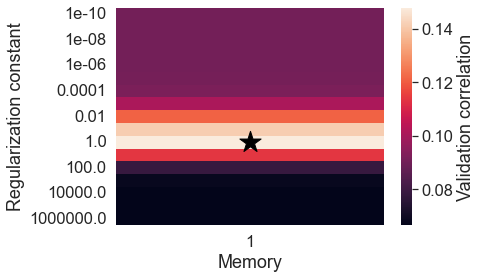

In [406]:
plot_heatmap(metrics, "Regularization constant", "Memory", metric="Correlation_r")

In [387]:
### Get data in lagged format
memory_std = 1
alpha_std = 1

X_lagged, y_lagged, R_lagged, dates_lagged = get_AR_format_with_features(r_tildes, memory_std, features, data, dates=dates, pred_horizon=pred_horizon)

X_train = X_lagged[:, :train_len+val_len]
y_train = y_lagged[:, :train_len+val_len]

X_test = X_lagged[:, train_len+val_len:]
y_test = y_lagged[:, train_len+val_len:]
R_train = R_lagged[:train_len+val_len]
R_test_std = R_lagged[train_len+val_len:]
dates_test_std = dates_lagged[train_len+val_len:]


# Train model
A_full = get_A(X_train, y_train, alpha_std, weighted=weighted)
r_tilde_hat_std = predict(A_full, X_test) 

r_hat_std = (sqrt_Sigma_hat @ r_tilde_hat_std.T).T


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat_std.flatten(), R_test_std.flatten())
print(f"Correlation: {r_value:.2%}")
print(f"Beta:  {slope:.2}")
print(f"Excess signs: {np.mean(np.sign(r_hat_std) == np.sign(R_test_std))-np.mean(R_test_std>0):.2%}")


Correlation: 3.70%
Beta:  0.29
Excess signs: -0.25%


# Full whitening

In [388]:
pred_horizon = 0
weighted = True
update_period = 252


T_half = 50

beta = np.exp(-np.log(2)/T_half)
EWMAs, r_tildes, R_new, skipped_R = get_whitened_data(data, whitener='Cov', beta=beta, EWMA_reg=0)

### Define features
sigmas = np.std(r_tildes[:train_len+val_len], axis=0).reshape(1,-1)
hi = get_hi(r_tildes, sigmas)
lo = get_lo(r_tildes, sigmas)
pos = get_pos(r_tildes)
neg = get_neg(r_tildes)

ma2 = moving_average(r_tildes, 2)
sigmas2 = np.std(ma2[:train_len+val_len], axis=0).reshape(1,-1)
hi2 = get_hi(ma2, sigmas2)
lo2 = get_lo(ma2, sigmas2)
pos2 = get_pos(ma2)
neg2 = get_neg(ma2)

ma4 = moving_average(r_tildes, 4)
sigmas4 = np.std(ma4[:train_len+val_len], axis=0).reshape(1,-1)
hi4 = get_hi(ma4, sigmas4)
lo4 = get_lo(ma4, sigmas4)
pos4 = get_pos(ma4)
neg4 = get_neg(ma4)

ma8 = moving_average(r_tildes, 8)
sigmas8 = np.std(ma8[:train_len+val_len], axis=0).reshape(1,-1)
hi8 = get_hi(ma8, sigmas8)
lo8 = get_lo(ma8, sigmas8)
pos8 = get_pos(ma8)
neg8 = get_neg(ma8)

ma16 = moving_average(r_tildes, 16)
sigmas16 = np.std(ma16[:train_len+val_len], axis=0).reshape(1,-1)
hi16 = get_hi(ma16, sigmas16)
lo16 = get_lo(ma16, sigmas16)
pos16 = get_pos(ma16)
neg16 = get_neg(ma16)

ma32 = moving_average(r_tildes, 32)
sigmas32 = np.std(ma32[:train_len+val_len], axis=0).reshape(1,-1)
hi32 = get_hi(ma32, sigmas32)
lo32 = get_lo(ma32, sigmas32)
pos32 = get_pos(ma32)
neg32 = get_neg(ma32)

features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, ma16, ma32, hi2, hi4, hi8, hi16, hi32, lo2, lo4, lo8, lo16, lo32,\
    pos2, pos4, pos8, pos16, pos32, neg2, neg4, neg8, neg16, neg32])

# features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, hi2, hi4, hi8, lo2, lo4, lo8,\
#     pos2, pos4, pos8, neg2, neg4, neg8])

# features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, ma16])

alphas = [10**i for i in range(-10,7)]
horizons = np.arange(1,21)
horizons = [1]

correlations_r = []
MSEs_r = []
correlations_tilde = []
MSEs_tilde = []
for i in trange(len(alphas)):
    alpha = alphas[i]
    for memory in horizons:

        ### Get data in lagged format
        X_lagged, y_lagged, R_lagged, EWMAs_lagged = get_AR_format_with_features(r_tildes, memory, features, R_new, EWMAs, pred_horizon=pred_horizon)

        X_train = X_lagged[:, :train_len]
        X_val = X_lagged[:, train_len:train_len+val_len]
        y_train = y_lagged[:, :train_len]
        y_val = y_lagged[:, train_len:train_len+val_len]
        EWMAs_train = EWMAs_lagged[:train_len]
        EWMAs_val = EWMAs_lagged[train_len:train_len+val_len]
        R_train = R_lagged[:train_len]
        R_val = R_lagged[train_len:train_len+val_len]

        # Train model
        As, X_vals, R_vals = get_As(X_train, y_train, X_val, y_val, R_val, alpha, weighted, update_period)
        r_tilde_hat, R = predict_periodically(As, X_vals, R_vals)

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_tilde_hat.flatten(), y_val.T.flatten())

        correlations_tilde.append([alpha, memory, r_value, slope])
        MSEs_tilde.append([alpha, memory, np.sqrt(np.mean((r_tilde_hat-y_val.T)**2))])

        r_hat = get_R(EWMAs_val, r_tilde_hat)

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat.flatten(), R.flatten())
        
        excess_signs = np.mean(np.sign(r_hat) == np.sign(R_val))-np.mean(R_val>0)

        correlations_r.append([alpha, memory, r_value, slope, excess_signs])
        MSEs_r.append([alpha, memory, np.sqrt(np.mean((r_hat-R_val)**2))])

correlations_r = np.array(correlations_r)
MSEs_r = np.array(MSEs_r)
correlations_tilde = np.array(correlations_tilde)
MSEs_tilde = np.array(MSEs_tilde)
metrics = {"MSE_r": MSEs_r, "Correlation_r": correlations_r, "MSE_tilde": MSEs_tilde, "Correlation_tilde": correlations_tilde}

100%|██████████| 17/17 [00:10<00:00,  1.62it/s]


Best x:  1.0
Best y:  1.0
Maximum validation corr: 15.45%
beta: 0.79
excess signs: 4.17%


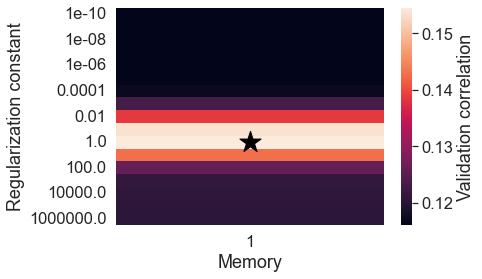

In [389]:
plot_heatmap(metrics, "Regularization constant", "Memory", metric="Correlation_r")

In [390]:
### Get data in lagged format
memory_full = 1
alpha_full = 1
 
X_lagged, y_lagged, R_lagged, EWMAs_lagged,\
     dates_lagged = get_AR_format_with_features(r_tildes, memory_full, features, R_new, EWMAs, dates=dates[skipped_R:], pred_horizon=pred_horizon)
X_train = X_lagged[:, :train_len+val_len]
y_train = y_lagged[:, :train_len+val_len]

X_test = X_lagged[:, train_len+val_len:]
y_test = y_lagged[:, train_len+val_len:]
EWMAs_train = EWMAs_lagged[:train_len+val_len]
EWMAs_test = EWMAs_lagged[train_len+val_len:]
R_train = R_lagged[:train_len+val_len]
R_test_full = R_lagged[train_len+val_len:]
dates_test_full = dates_lagged[train_len+val_len:]


# Train model
As_full, X_tests, R_tests_full = get_As(X_train, y_train, X_test, y_test, R_test_full, alpha_full, weighted, update_period=update_period)
r_tilde_hat, R = predict_periodically(As_full, X_tests, R_tests_full)
r_hat_full = get_R(EWMAs_test, r_tilde_hat)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat_full.flatten(), R_test_full.flatten())
print(f"Correlation: {r_value:.2%}")
print(f"Beta:  {slope:.2}")
print(f"Excess signs: {np.mean(np.sign(r_hat_full) == np.sign(R_test_full))-np.mean(R_test_full>0):.2%}")

Correlation: 5.44%
Beta:  0.51
Excess signs: 1.12%


# Tripple whitening

In [453]:
pred_horizon = 0
weighted = True
update_period = 252


T_half1 = 5
T_half2 = 21 
T_half3 = 63

beta1 = np.exp(-np.log(2)/T_half1)
beta2 = np.exp(-np.log(2)/T_half2)
beta3 = np.exp(-np.log(2)/T_half3)

(sqrt_size_hats, sqrt_V_hats, sqrt_Sigma_hats), (r_tildes_size, r_tildes_var, r_tildes_full), R_new, skipped_R  \
    = get_whitened_data(data, whitener='tripple', beta=(beta1,beta2,beta3), EWMA_reg=0)
EWMAs = (sqrt_size_hats, sqrt_V_hats, sqrt_Sigma_hats)
tildes = (r_tildes_size, r_tildes_var, r_tildes_full)


### Define features
sigmas = np.std(r_tildes_full[:train_len+val_len], axis=0).reshape(1,-1)
hi = get_hi(r_tildes_full, sigmas)
lo = get_lo(r_tildes_full, sigmas)
pos = get_pos(r_tildes_full)
neg = get_neg(r_tildes_full)

ma2 = moving_average(r_tildes_full, 2)
sigmas2 = np.std(ma2[:train_len+val_len], axis=0).reshape(1,-1)
hi2 = get_hi(ma2, sigmas2)
lo2 = get_lo(ma2, sigmas2)
pos2 = get_pos(ma2)
neg2 = get_neg(ma2)

ma4 = moving_average(r_tildes_full, 4)
sigmas4 = np.std(ma4[:train_len+val_len], axis=0).reshape(1,-1)
hi4 = get_hi(ma4, sigmas4)
lo4 = get_lo(ma4, sigmas4)
pos4 = get_pos(ma4)
neg4 = get_neg(ma4)

ma8 = moving_average(r_tildes_full, 8)
sigmas8 = np.std(ma8[:train_len+val_len], axis=0).reshape(1,-1)
hi8 = get_hi(ma8, sigmas8)
lo8 = get_lo(ma8, sigmas8)
pos8 = get_pos(ma8)
neg8 = get_neg(ma8)

ma16 = moving_average(r_tildes_full, 16)
sigmas16 = np.std(ma16[:train_len+val_len], axis=0).reshape(1,-1)
hi16 = get_hi(ma16, sigmas16)
lo16 = get_lo(ma16, sigmas16)
pos16 = get_pos(ma16)
neg16 = get_neg(ma16)

ma32 = moving_average(r_tildes_full, 32)
sigmas32 = np.std(ma32[:train_len+val_len], axis=0).reshape(1,-1)
hi32 = get_hi(ma32, sigmas32)
lo32 = get_lo(ma32, sigmas32)
pos32 = get_pos(ma32)
neg32 = get_neg(ma32)

# ma64 = moving_average(r_tildes_full, 64)
# sigmas64 = np.std(ma64[:train_len+val_len], axis=0).reshape(1,-1)
# hi64 = get_hi(ma64, sigmas64)
# lo64 = get_lo(ma64, sigmas64)
# pos64 = get_pos(ma64)
# neg64 = get_neg(ma64)

features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, ma16, ma32, hi2, hi4, hi8, hi16, hi32, lo2, lo4, lo8, lo16, lo32,\
    pos2, pos4, pos8, pos16, pos32, neg2, neg4, neg8, neg16, neg32])


# features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, hi2, hi4, hi8, lo2, lo4, lo8,\
#     pos2, pos4, pos8, neg2, neg4, neg8])

# features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, ma16])

alphas = [10**i for i in range(-10,7)]
horizons = np.arange(1,21)
horizons = [1]

correlations_r = []
MSEs_r = []
correlations_tilde = []
MSEs_tilde = []
for i in trange(len(alphas)):
    alpha = alphas[i]
    for memory in horizons:

        ### Get data in lagged format
        X_lagged, y_lagged, R_lagged, EWMAs_lagged = get_AR_format_with_features(r_tildes_full, memory, features, R_new, EWMAs, pred_horizon=pred_horizon)

        X_train = X_lagged[:, :train_len]
        X_val = X_lagged[:, train_len:train_len+val_len]
        y_train = y_lagged[:, :train_len]
        y_val = y_lagged[:, train_len:train_len+val_len]
        EWMAs_train = (EWMAs_lagged[0][:train_len], EWMAs_lagged[1][:train_len], EWMAs_lagged[2][:train_len])
        EWMAs_val = (EWMAs_lagged[0][train_len:train_len+val_len], EWMAs_lagged[1][train_len:train_len+val_len], EWMAs_lagged[2][train_len:train_len+val_len])
        R_train = R_lagged[:train_len]
        R_val = R_lagged[train_len:train_len+val_len]

        # Train model
        As, X_vals, R_vals = get_As(X_train, y_train, X_val, y_val, R_val, alpha, weighted, update_period)
        r_tilde_full_hat, R = predict_periodically(As, X_vals, R_vals)
        r_tilde_var_hat = get_R(EWMAs_val[2], r_tilde_full_hat)
        r_tilde_size_hat = get_R(EWMAs_val[1], r_tilde_var_hat)
        r_hat = r_tilde_size_hat * EWMAs_val[0]

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat.flatten(), R.flatten())
        
        excess_signs = np.mean(np.sign(r_hat) == np.sign(R_val))-np.mean(R_val>0)

        correlations_r.append([alpha, memory, r_value, slope, excess_signs])
        MSEs_r.append([alpha, memory, np.sqrt(np.mean((r_hat-R_val)**2))])

correlations_r = np.array(correlations_r)
MSEs_r = np.array(MSEs_r)
correlations_tilde = np.array(correlations_tilde)
MSEs_tilde = np.array(MSEs_tilde)
metrics = {"MSE_r": MSEs_r, "Correlation_r": correlations_r, "MSE_tilde": MSEs_tilde, "Correlation_tilde": correlations_tilde}

100%|██████████| 17/17 [00:11<00:00,  1.45it/s]


Best x:  1.0
Best y:  0.1
Maximum validation corr: 16.33%
beta: 0.61
excess signs: 4.41%


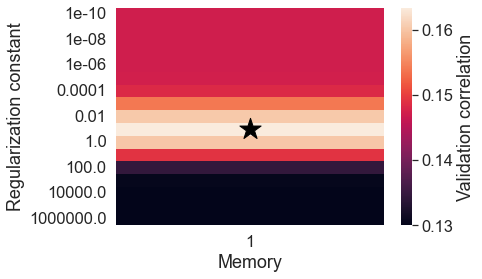

In [454]:
plot_heatmap(metrics, "Regularization constant", "Memory", metric="Correlation_r")

In [455]:
memory_tripple = 1
alpha_tripple = 0.1

### Get data in lagged format
X_lagged, y_lagged, R_lagged, EWMAs_lagged,\
    dates_lagged = get_AR_format_with_features(r_tildes_full, memory_tripple, features, R_new, EWMAs, dates=dates[skipped_R:], pred_horizon=pred_horizon)

X_train = X_lagged[:, :train_len+val_len]
y_train = y_lagged[:, :train_len+val_len]
X_test = X_lagged[:, train_len+val_len:]
y_test = y_lagged[:, train_len+val_len:]

EWMAs_train = (EWMAs_lagged[0][:train_len+val_len], EWMAs_lagged[1][:train_len+val_len], EWMAs_lagged[2][:train_len+val_len])
EWMAs_test_tripple = (EWMAs_lagged[0][train_len+val_len:], EWMAs_lagged[1][train_len+val_len:], EWMAs_lagged[2][train_len+val_len:])
R_train = R_lagged[:train_len+val_len]
R_test_tripple = R_lagged[train_len+val_len:]
dates_test_tripple = dates_lagged[train_len+val_len:]


# Train model
As_tripple, X_tests, R_tests_tripple = get_As(X_train, y_train, X_test, y_test, R_test_tripple, alpha_tripple, weighted, update_period)
r_tilde_full_hat, R = predict_periodically(As_tripple, X_tests, R_tests_tripple)
r_tilde_var_hat = get_R(EWMAs_test_tripple[2], r_tilde_full_hat)
r_tilde_size_hat = get_R(EWMAs_test_tripple[1], r_tilde_var_hat)
r_hat_tripple = r_tilde_size_hat * EWMAs_test_tripple[0]


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat_tripple.flatten(), R_test_tripple.flatten())
print(f"Correlation: {r_value:.2%}")
print(f"Beta:  {slope:.2}")
print(f"Excess signs: {np.mean(np.sign(r_hat_tripple) == np.sign(R_test_tripple))-np.mean(R_test_tripple>0):.2%}")

Correlation: 6.33%
Beta:  0.42
Excess signs: 1.28%


In [457]:
df_R_full = pd.DataFrame(R_test_tripple, index=dates_test_tripple)
df_r_hat_fake = pd.DataFrame(r_hat_tripple, index=dates_test_tripple)
all_years = df_r_hat_fake.index.year.unique()

corrs_tripple = []
for year in all_years:
    R_test = df_R_full[df_R_full.index.year == year].values
    r_hat = df_r_hat_fake[df_r_hat_fake.index.year == year].values
    corrs_tripple.append(np.corrcoef(R_test.flatten(), r_hat.flatten())[0, 1])
    print(f"Correlation: (year {year})  {corrs_tripple[-1]:.2%} ({R_test.shape[0]} data points)")
print("Avg. :", np.mean(corrs_tripple))
print("Correlation on all data:", np.corrcoef(r_hat_tripple.flatten(), R_test_tripple.flatten())[0,1])

Correlation: (year 2006)  5.70% (209 data points)
Correlation: (year 2007)  7.15% (251 data points)
Correlation: (year 2008)  8.96% (253 data points)
Correlation: (year 2009)  0.00% (252 data points)
Correlation: (year 2010)  6.20% (252 data points)
Correlation: (year 2011)  13.24% (252 data points)
Correlation: (year 2012)  2.03% (250 data points)
Correlation: (year 2013)  1.38% (252 data points)
Correlation: (year 2014)  7.97% (252 data points)
Correlation: (year 2015)  -6.75% (252 data points)
Correlation: (year 2016)  3.19% (252 data points)
Correlation: (year 2017)  2.52% (251 data points)
Correlation: (year 2018)  0.00% (251 data points)
Correlation: (year 2019)  5.52% (252 data points)
Correlation: (year 2020)  10.55% (253 data points)
Correlation: (year 2021)  5.03% (252 data points)
Correlation: (year 2022)  8.37% (188 data points)
Avg. : 0.04768771717341876
Correlation on all data: 0.06328741665598123


100%|██████████| 4374/4374 [01:41<00:00, 43.25it/s]


Mean yearly return (portfolio): 2.22%
Yearly risk (portfolio): 5.14%
Sharpe ratio:  0.43


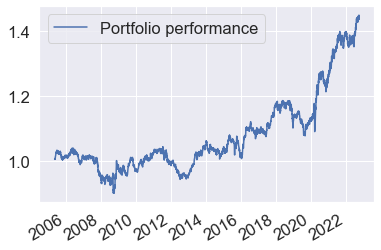

In [127]:
dates_diff = skipped_R + 1-1
dates_test_nw_new = dates_test_nw[dates_diff:]
r_hat_nw_new = r_hat_nw[dates_diff:]
R_test_nw_new = R_test_nw[dates_diff:]

trader_nw = Trader(R_test_nw_new, r_hat_nw_new, EWMAs_test, dates=dates_test_nw_new)
trader_nw.backtest(risk_des=0.05)
trader_nw.show_performance()

In [192]:
FF.std(axis=0)

Mkt-RF    0.010217
SMB       0.005414
HML       0.005777
RMW       0.003957
CMA       0.003740
dtype: float64

In [193]:
45*5

225

In [189]:
A_full.shape

(5, 45)

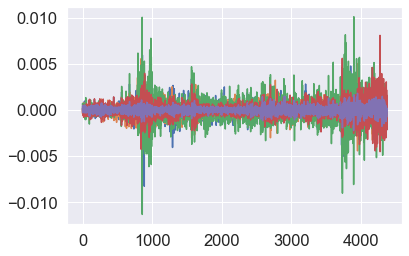

In [123]:
plt.plot(r_hat_full);

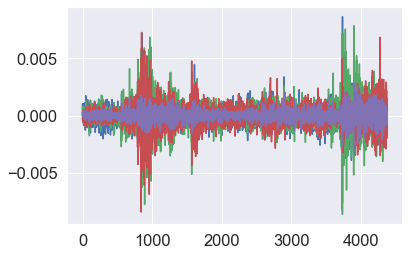

In [122]:
plt.plot(r_hat_nw_new);

100%|██████████| 14811/14811 [04:41<00:00, 52.57it/s]


Mean yearly return (portfolio): 3.51%
Yearly risk (portfolio): 3.23%
Sharpe ratio:  1.09


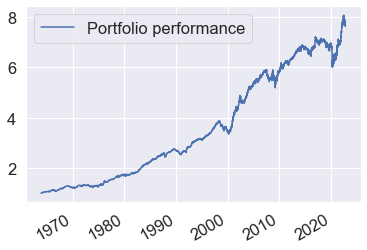

In [56]:
trader_full = Trader(R_test_full, r_hat_full, EWMAs_test, dates=dates_test_full)
trader_full.backtest(risk_des=0.05)
trader_full.show_performance()

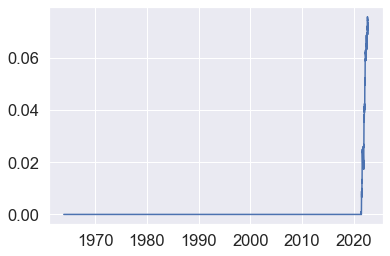

In [60]:
plt.plot(dates_test_full, trader_full.ws[:,0])

In [ ]:
df_R_full = pd.DataFrame(R_test_full, index=dates_test_full)
df_r_hat_fake = pd.DataFrame(r_hat_fake, index=dates_test_full)
all_years = df_r_hat_fake.index.year.unique()

corrs = []
for year in all_years:
    R_test = df_R_full[df_R_full.index.year == year].values
    r_hat = df_r_hat_fake[df_r_hat_fake.index.year == year].values
    corrs.append(np.corrcoef(R_test.flatten(), r_hat.flatten())[0, 1])
    print(f"Correlation: (year {year})  {corrs[-1]:.2%} ({R_test.shape[0]} data points)")
print("Avg. :", np.mean(corrs))
print("Correlation on all data:", np.corrcoef(r_hat_full.flatten(), R_test_full.flatten())[0,1])